D7041E MiniProject by Dino Lolic and Oliver Johdet Piwek

The project is image classification using CNN, specifically to classify xray images and
correctly differentiating between healthy patients and patients sick with pneumonia based on chest x-ray images.

Python version:
3.9.13

Dependencies (python packages):
matploblib
numpy
pandas
scikit-learn
keras
seaborn
tensorflow
jupyter

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
#Paths to the data used in the project
train_path = 'chest_xray/train'  #Train set
test_path = 'chest_xray/test'  #Test set
valid_path = 'chest_xray/val'  #Validation set
#The dimension of the images we are going to define is 500x500
img_height = 500
img_width = 500

In [4]:
from keras.preprocessing.image import ImageDataGenerator


def preprocessing(batch_size):
    #Data augmentation used to artificially incraese the size of image training dataset. This will improve the models ability to predict new images

    #The image data generator for the training set
    image_gen = ImageDataGenerator(
        rescale=1. / 255,  #make the image contribute equally
        shear_range=0.2,  #streatces the image at a certain angle
        zoom_range=0.2,  #The image is enlarged
        horizontal_flip=True,  #Randomly flip some images horizontaly
    )

    #The image data generator for the test and validation sets
    test_data_gen = ImageDataGenerator(rescale=1. / 255)

    #Load the images
    train = image_gen.flow_from_directory(
        train_path,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=batch_size
    )

    valid = test_data_gen.flow_from_directory(
        valid_path,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=batch_size
    )

    test = test_data_gen.flow_from_directory(
        test_path,
        target_size=(img_height, img_width),
        color_mode='grayscale', shuffle=False,  #Shuffle here is false to prevent indexing complications
        class_mode='binary',
        batch_size=batch_size
    )
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train.classes),
        y=train.classes
    )



    return train, valid, weights, test

In [5]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(256, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=256))
cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 128)      0

In [7]:
cnn.summary()
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 128)      0

In [8]:
def run(batch_size, epochs, runs):
    current_run = 0

    train, valid, weights, test = preprocessing(batch_size)

    cw = dict(zip(np.unique(train.classes), weights))

    while current_run < runs:
        print("Run:", current_run)
        cnn.fit(train, epochs=epochs, validation_data=valid, class_weight=cw, callbacks=callbacks_list)
        current_run += 1

    test_accu = cnn.evaluate(test)
    print('The testing accuracy is :', test_accu[1] * 100, '%')

    preds = cnn.predict(test, verbose=1)
    predictions = preds.copy()
    predictions[predictions <= 0.5] = 0 #Normal case
    predictions[predictions > 0.5] = 1  #Pneumonia case
    from sklearn.metrics import classification_report, confusion_matrix

    cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                      index=["Actual Normal", "Actual Pneumonia"],
                      columns=["Predicted Normal", "Predicted Pneumonia"])
    import seaborn as sns

    sns.heatmap(cm, annot=True, fmt="d")
    print(classification_report(y_true=test.classes, y_pred=predictions, target_names=['NORMAL', 'PNEUMONIA']))

    test.reset()
    x = np.concatenate([test.next()[0] for i in range(test.__len__())])
    y = np.concatenate([test.next()[1] for i in range(test.__len__())])
    print(x.shape)
    print(y.shape)
    #this little code above extracts the images from test Data iterator without shuffling the sequence
    # x contains image array and y has labels
    dic = {0: 'NORMAL', 1: 'PNEUMONIA'}
    plt.figure(figsize=(20, 20))
    for i in range(228, 9 + 228):
        if preds[i, 0] >= 0.5: #if Pneumonia:
            out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
            plt.title(out + "\n Actual case : " + dic.get(y[i]))
            plt.imshow(np.squeeze(x[i]))
            plt.axis('off')
            plt.show()

        else:
            out = ('{:.2%} probability of being Normal case'.format(1 - preds[i][0]))
            plt.title(out + "\n Actual case : " + dic.get(y[i]))
            plt.imshow(np.squeeze(x[i]))
            plt.axis('off')
            plt.show()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Run: 0
Epoch 1/8
326/326 [==============================] - 610s 2s/step - loss: 0.4428 - accuracy: 0.7770 - val_loss: 0.9846 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/8
326/326 [==============================] - 601s 2s/step - loss: 0.2572 - accuracy: 0.9034 - val_loss: 0.7347 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/8
326/326 [==============================] - 621s 2s/step - loss: 0.2289 - accuracy: 0.9068 - val_loss: 1.0928 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/8
326/326 [==============================] - 603s 2s/step - loss: 0.2100 - accuracy: 0.9168 - val_loss: 0.6307 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/8
326/326 [==============================] - 599s 2s/step - loss: 0.1929 - accuracy: 0.9260 - val_loss: 0.4331 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/8
326/326 [==============================] - 600s 2s/step - loss: 0.1537 - accuracy: 0.

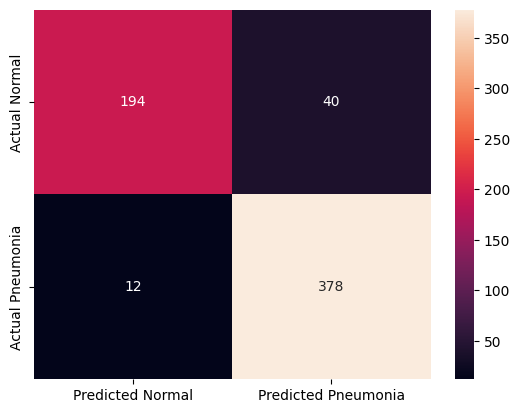

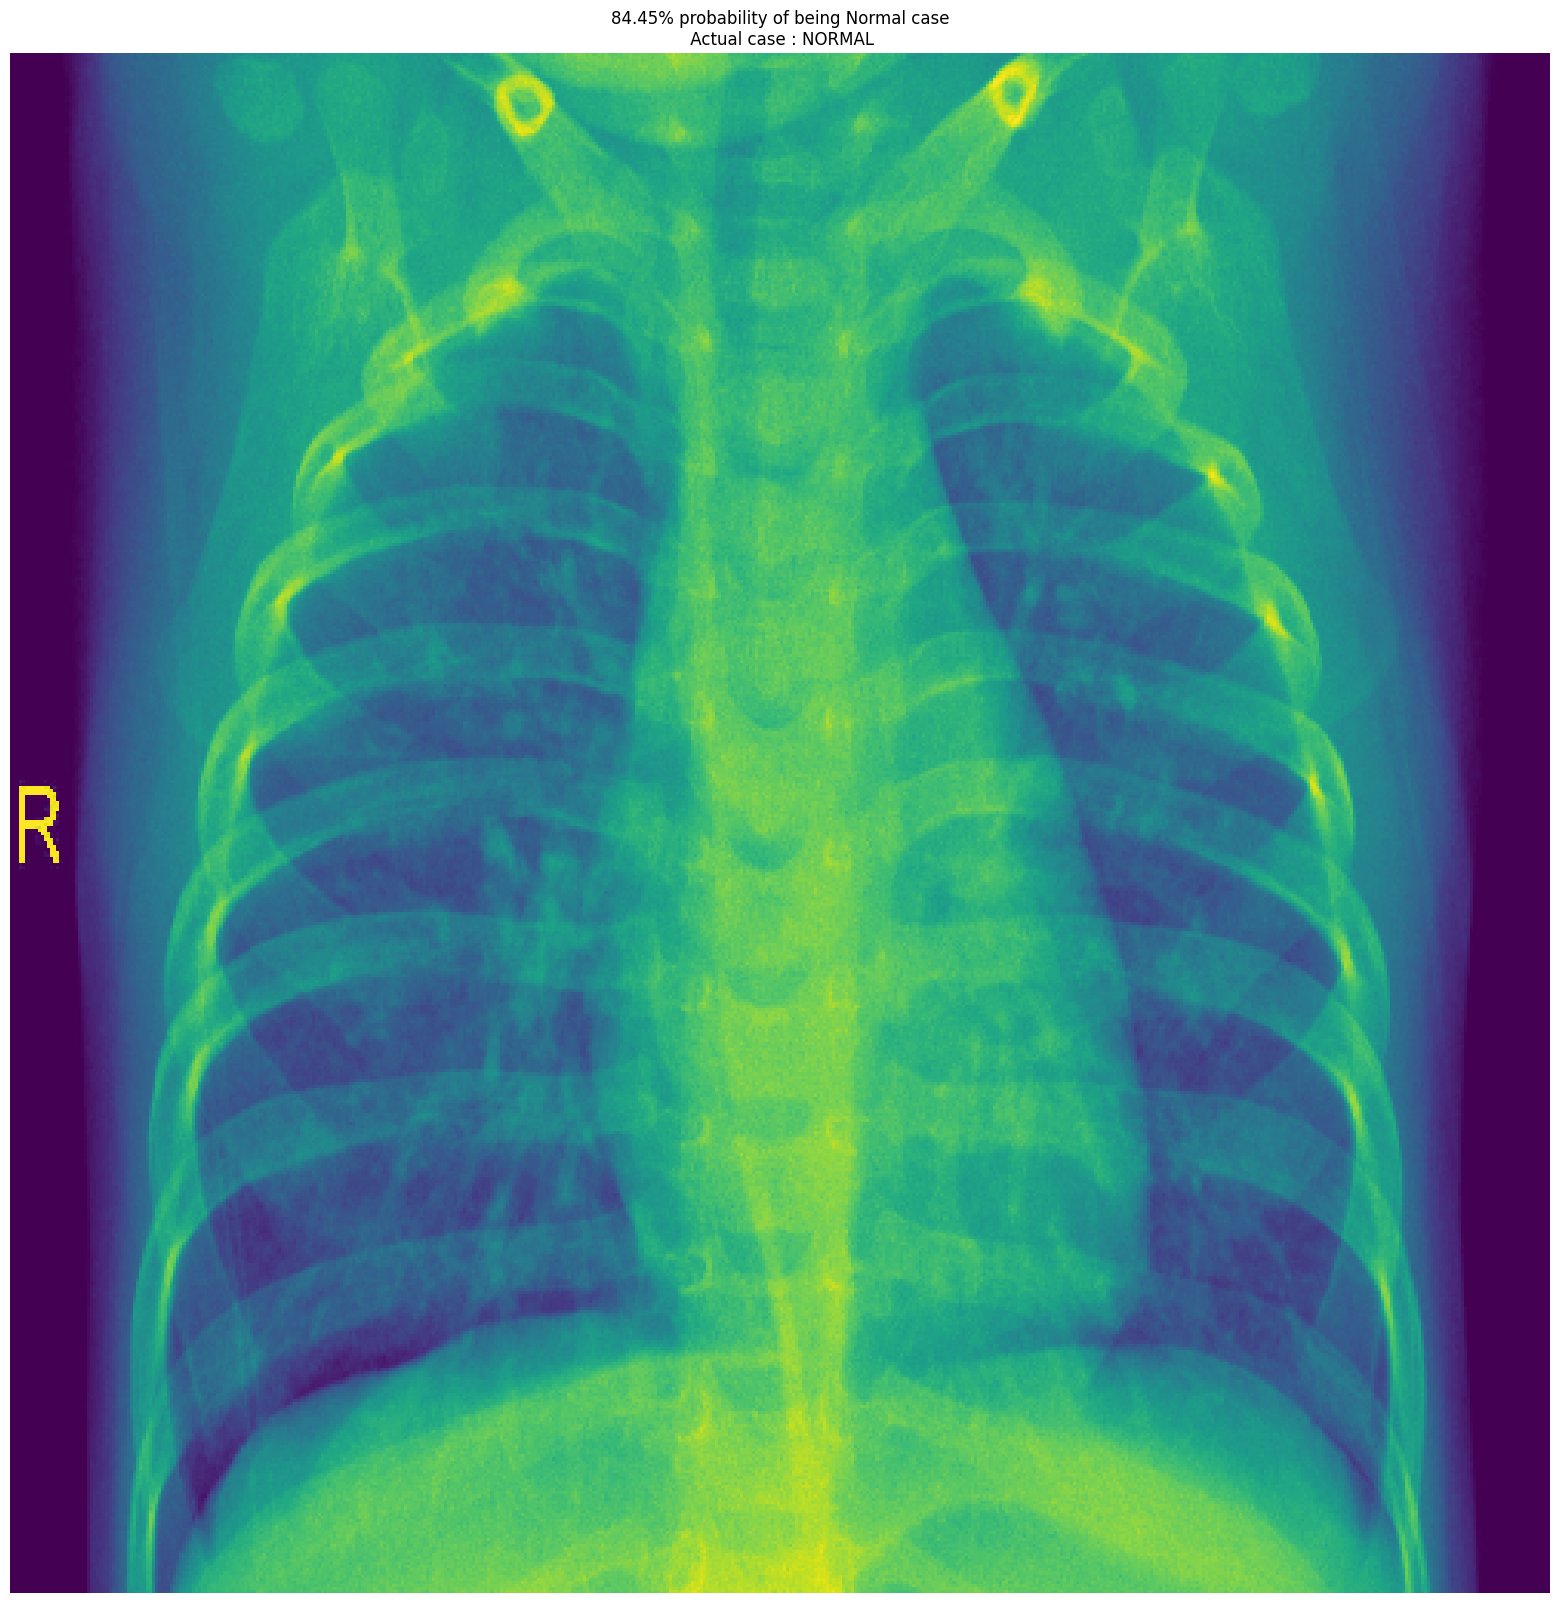

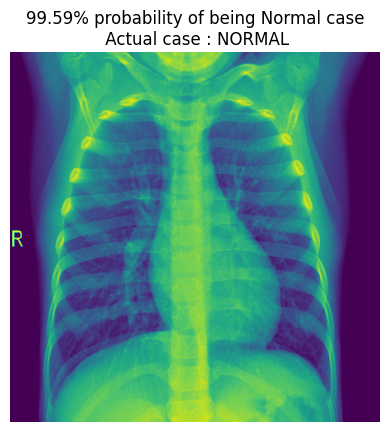

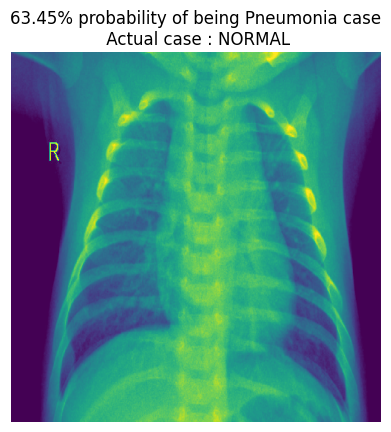

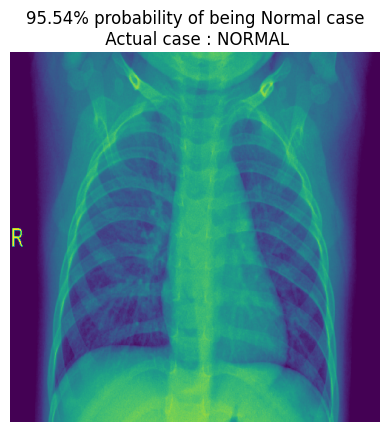

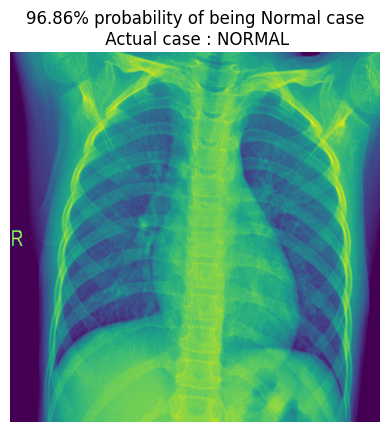

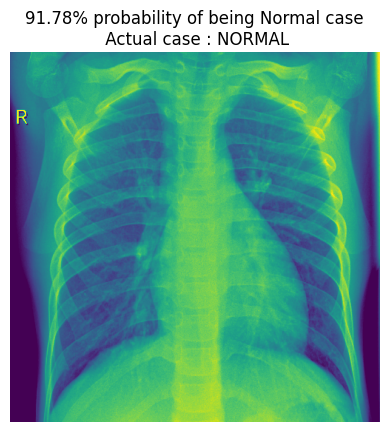

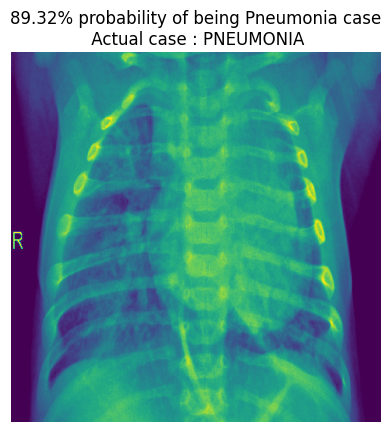

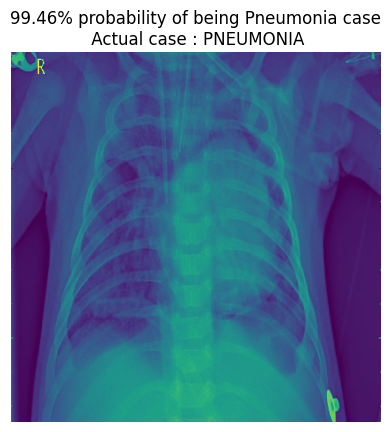

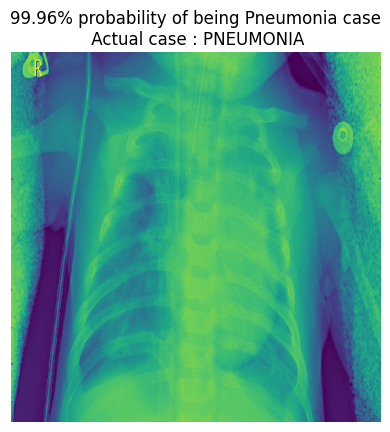

In [9]:
run(16, 8, 1)  #Batch size = 16 , Epochs = 8, runs = 1